In [1]:
import os
import matplotlib.pyplot as plt
import imghdr
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cat_images = '/content/drive/MyDrive/ml/train/cat/'
rabbit_images='/content/drive/MyDrive/ml/train/rabbit/'

In [ ]:
#performing image integrity check

def integrity_check(directory):
    print(f"Checking images in '{directory}':")

    counter=0
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)

        file_type = imghdr.what(file_path) #using imghdr to get a clue about the image file type in the directory

        if file_type is not None:
            img = cv2.imread(file_path)
            counter+=1

            if img is None:
                print(f"Image '{filename}' with type '{file_type}' is corrupted or cannot be opened.")  #in this way I can find out if the corrupted file is an image or is there another file type in the directory

        else:
            print(f"Skipping file '{filename}' as it is not an image.")

    print("Integrity check successful. Type of image files: ", file_type )
    print("Number of valid images in directory: ",counter)

# For cat images
integrity_check(cat_images)

# For rabbit images
integrity_check(rabbit_images)


Checking images in '/content/drive/MyDrive/ml/train/cat/':
Integrity check successful. Type of image files:  jpeg
Number of valid images in directory:  800
Checking images in '/content/drive/MyDrive/ml/train/rabbit/':
Integrity check successful. Type of image files:  jpeg
Number of valid images in directory:  796


Number of cat images: 800
Number of rabbit images: 796


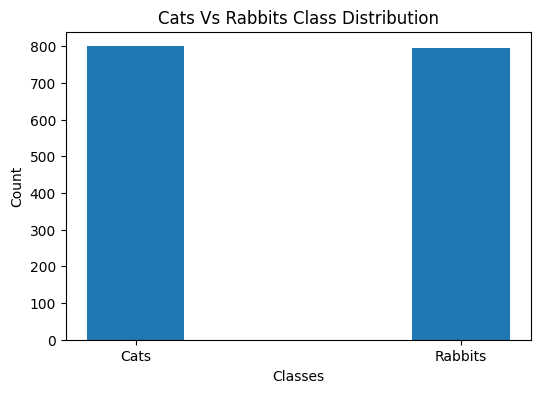

In [ ]:
#checking number of images in each class and visualizing class distribution

def data_statistics(cat_images, rabbit_images):

    num_cats = len(os.listdir(cat_images))
    num_rabbits = len(os.listdir(rabbit_images))

    print("Number of cat images:", num_cats)
    print("Number of rabbit images:", num_rabbits)

    class_labels = ['Cats', 'Rabbits']
    class_counts = [num_cats, num_rabbits]

    plt.figure(figsize=(6, 4))
    plt.bar(class_labels, class_counts, width=0.3, align='center')
    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.title('Cats Vs Rabbits Class Distribution')
    plt.show()

data_statistics(cat_images, rabbit_images)

In [ ]:
def resize(directory, size_threshold):
    images_removed = 0
    images_retained = 0
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)

        file_size = os.path.getsize(file_path)

        if file_size < size_threshold:
            os.remove(file_path)
            images_removed +=1
        else:
            images_retained +=1
    print(f'directory : {directory}')
    print(f'Images Removed: {images_removed}')
    print(f'Images Retained: {images_retained}')
size_threshold = 10000  # The size is in bytes so here I have set size limit to 10kb

resize(cat_images, size_threshold)
resize(rabbit_images, size_threshold)


directory : /content/drive/MyDrive/ml/train/cat/
Images Removed: 0
Images Retained: 800
directory : /content/drive/MyDrive/ml/train/rabbit/
Images Removed: 0
Images Retained: 796


Number of cat images: 800
Number of rabbit images: 796


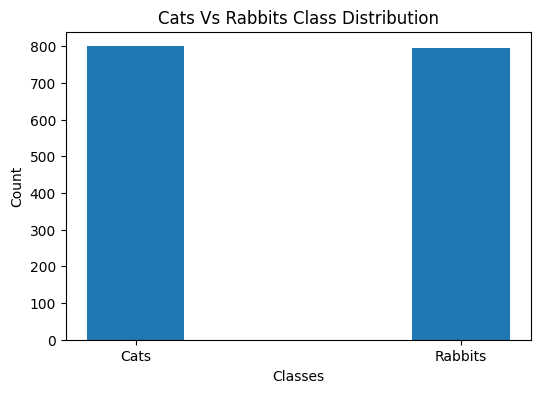

In [ ]:
#calling data_statistics function again to visualize class counts after resizing and removing

data_statistics(cat_images, rabbit_images)

In [ ]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 15921, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 15921 (delta 16), reused 22 (delta 8), pack-reused 15880
Receiving objects: 100% (15921/15921), 14.66 MiB | 17.74 MiB/s, done.
Resolving deltas: 100% (10911/10911), done.


In [ ]:
%cd yolov5

/content/yolov5/yolov5


In [ ]:
pip install ultralytics

In [ ]:
!python classify/train.py --model yolov5s-cls.pt --data /content/drive/MyDrive/ --epochs 5 --img 224 --cache

classify/train: model=yolov5s-cls.pt, data=/content/drive/MyDrive/, epochs=5, batch_size=64, imgsz=224, nosave=False, cache=ram, device=, workers=8, project=runs/train-cls, name=exp, exist_ok=False, pretrained=True, optimizer=Adam, lr0=0.001, decay=5e-05, label_smoothing=0.1, cutoff=None, dropout=None, verbose=False, seed=0, local_rank=-1
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-210-gdd10481 Python-3.10.12 torch-2.0.1+cu118 CPU

TensorBoard: Start with 'tensorboard --logdir runs/train-cls', view at http://localhost:6006/
albumentations: RandomResizedCrop(p=1.0, height=224, width=224, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=1), HorizontalFlip(p=0.5), ColorJitter(p=0.5, brightness=[0.6, 1.4], contrast=[0.6, 1.4], saturation=[0.6, 1.4], hue=[0, 0]), Normalize(p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0), ToTensorV2(always_apply=True, p=1.0, transpose_mask=False)
100% 10.5M/10.5M [00:00<

In [ ]:
from math import floor
import os
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from tqdm import tqdm

# Path to validation images
# Path to validation images
val_cat_images = '/content/drive/MyDrive/val/cat'
val_rabbit_images = '/content/drive/MyDrive/val/rabbit'

# Load the trained model weights
model_weights = torch.load('best.pt', map_location=torch.device('cpu'))

# Load the model architecture
model = model_weights['model'].float().eval()

# Transformation to preprocess input images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to classify images and calculate accuracy
def validate_model(model, image_directory):
    correct_predictions = 0
    total_predictions = 0

    for filename in tqdm(os.listdir(image_directory), desc='Validating'):
        img_path = os.path.join(image_directory, filename)
        image = Image.open(img_path).convert('RGB')
        image_tensor = transform(image).unsqueeze(0)

        with torch.no_grad():
            output = model(image_tensor)
            predicted_class = torch.argmax(output)

        if predicted_class == 0 and image_directory == val_cat_images:
            correct_predictions += 1
        elif predicted_class == 1 and image_directory == val_rabbit_images:
            correct_predictions += 1

        total_predictions += 1

    accuracy = correct_predictions / total_predictions
    return accuracy

# Validate the model on cat and rabbit validation images
cat_accuracy = validate_model(model, val_cat_images)
rabbit_accuracy = validate_model(model, val_rabbit_images)


# Plot the results
classes = ['Cat', 'Rabbit']
accuracies = [round(cat_accuracy*100) , round(rabbit_accuracy*100)]

print(accuracies)


Validating: 100%|██████████| 207/207 [00:10<00:00, 19.99it/s]

[99, 99]
